# What Model : Convolutional Neural Network Model

### What is solved : MultiClass Classification
### Multi class label indicating rust or powdery and healthy
### Use the Plant Disease Recognition Dataset, which contains 1,530 images divided into train, test, and validation sets. The images are labeled as “Healthy“, “Rust“, and “Powdery“ to describe the conditions of the plants.

# 1. Install Required Libraries & Setup Path

In [74]:
!pip install pandas numpy plotly ipython scipy statsmodels scikit-learn catboost xgboost lightgbm optuna Pillow

In [75]:
# Data Handling
import pandas as pd
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# Efficient Looping
import itertools

# Traceback for diagnosis
import traceback

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest
import math

# Feature Selection
from sklearn.feature_selection import (
    RFECV, SelectKBest, chi2, f_classif, f_regression,
    mutual_info_classif, mutual_info_regression
)

# Machine Learning Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin

# Preprocessing data
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Model Selection for Cross Validation
from sklearn.model_selection import (
    StratifiedKFold, KFold, 
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, TimeSeriesSplit
)

# Machine Learning metrics
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    cohen_kappa_score,
    make_scorer,
    roc_curve,
    auc,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

# ML regressors
from sklearn.linear_model import HuberRegressor,RANSACRegressor, TheilSenRegressor, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.ensemble import (
    HistGradientBoostingRegressor, StackingRegressor, 
    AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, StackingRegressor, VotingRegressor
    )
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# ML classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import (
    HistGradientBoostingClassifier, AdaBoostClassifier, 
    RandomForestClassifier, GradientBoostingClassifier,
    StackingClassifier, VotingClassifier,ExtraTreesClassifier
    )
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Clustering algorithms
from sklearn.cluster import KMeans

# Fine-tuning 
import optuna

# Randomizer
import random

# Encoder of categorical variables
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# OS
import os

# Image package
from PIL import Image

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

In [76]:
# Importing Keras 
from tensorflow.keras.models import Sequential                          # Neural network model as a sequence of layers.
from tensorflow.keras.layers import Conv2D                              # Convolutional layer
from tensorflow.keras.layers import MaxPooling2D                        # Max pooling layer 
from tensorflow.keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from tensorflow.keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from tensorflow.keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from tensorflow.keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from tensorflow.keras.layers import Activation                          # Layer for activation functions
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from tensorflow.keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

In [77]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'
#colormap = 
#template = 

In [78]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# *Building Process*

# 2. Explore Dataset Structure

# 2.1 Analysis of the data

In [79]:
# Loading training, testing, and validation directories
train_dir = r'D:\Yumna\plant_disease_dataset\Train\Train'
test_dir = r'D:\Yumna\plant_disease_dataset\Test\Test'
val_dir = r'D:\Yumna\plant_disease_dataset\Validation\Validation'

## 2.1.1 Count the files inside each subfolder 

In [80]:
# To compute the total of data we have for training and testing, as well as measure the degree of class imbalance.
import os
# Give names to each directory
directories = {
    train_dir: 'Train',
    test_dir: 'Test',
    val_dir: 'Validation'
}

# Naming subfolders
subfolders = ['Healthy','Powdery','Rust']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)



* * * * * Number of files in each folder * * * * *


Train/Healthy: 458

Train/Powdery: 430

Train/Rust: 434

  Total: 1322
--------------------------------------------------------------------------------

Test/Healthy: 12

Test/Powdery: 50

Test/Rust: 50

  Total: 112
--------------------------------------------------------------------------------

Validation/Healthy: 20

Validation/Powdery: 20

Validation/Rust: 20

  Total: 60
--------------------------------------------------------------------------------


### 2.1.2 Shows the images with unique and same dimensions

In [81]:
unique_dimensions = set()

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)

if len(unique_dimensions) == 1:
    print(f"\All images have the same dimensions: {unique_dimensions.pop()}")
else:
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")


Found 7 unique image dimensions: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (4608, 3456), (2421, 2279)}


### 2.1.3 Checking distribution of these dimensions across the data

In [82]:
# Checking if all the images in the dataset have the same dimensions
dims_counts = defaultdict(int)

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                dims_counts[img.size] += 1
                
for dimension, count in dims_counts.items():
    print(f"\nDimension {dimension}: {count} images")


Dimension (4000, 3000): 87 images

Dimension (4000, 2672): 1094 images

Dimension (2421, 2279): 1 images

Dimension (2592, 1728): 127 images

Dimension (5184, 3456): 97 images

Dimension (4608, 3456): 72 images

Dimension (4032, 3024): 16 images


### 2.1.4 Checking images dtype

In [83]:
# Checking images dtype
all_uint8 = True
all_in_range = True

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                img_array = np.array(img)
                
            if img_array.dtype == 'uint8':
                all_uint8 = False
            
            if img_array.min() < 0 or img_array.max() > 255:
                all_in_range = False
                
if all_uint8:
    print(" - All images are of data type uint8\n")
else:
    print(" - Not all images are of data type uint8\n")
    
if all_in_range:
    print(" - All images have pixel values ranging from 0 to 255")
else:
    print(" - Not all images have the same pixel values from 0 to 255")

 - Not all images are of data type uint8

 - All images have pixel values ranging from 0 to 255


# 2.2 Visual Analization of images

In [84]:
# Loading the directory for each class in the training dataset
train_healthy_dir = train_dir + "/" + 'Healthy'
train_rust_dir = train_dir + "/" + 'Rust'
train_powdery_dir = train_dir + "/" + 'Powdery'

# Selecting 9 random pictures from each directory
healthy_files = random.sample(os.listdir(train_healthy_dir), 9)
rust_files = random.sample(os.listdir(train_rust_dir), 9)
powdery_files = random.sample(os.listdir(train_powdery_dir), 9)

In [85]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_list(image_paths, title, dataset_type):
    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(image_paths[:6]):
        plt.subplot(2, 3, i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"{dataset_type}\n{os.path.basename(img_path)}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

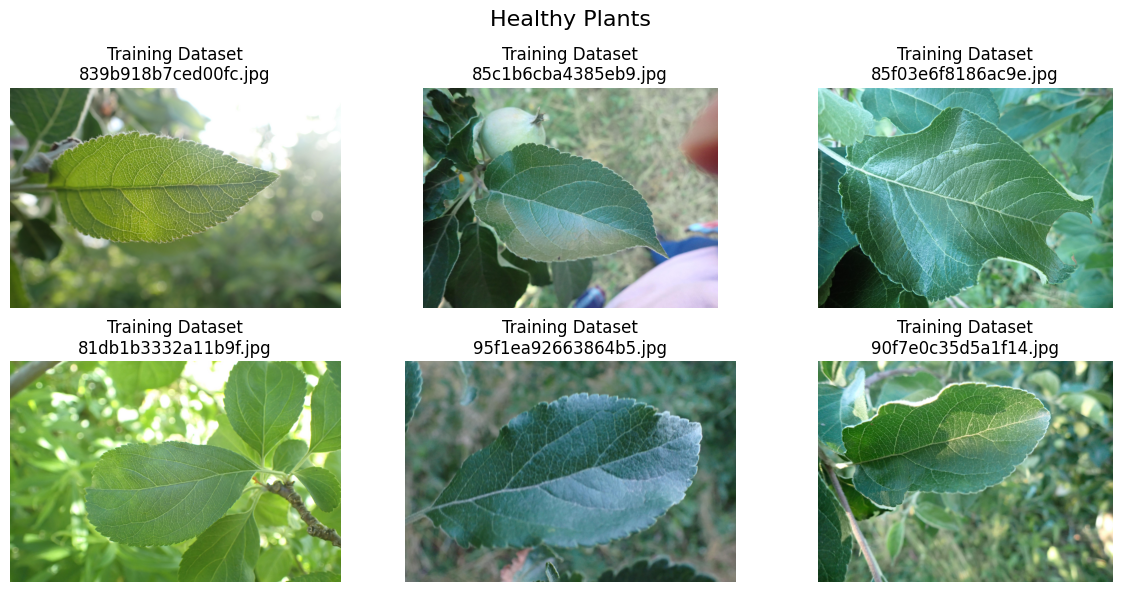

In [86]:
# Plotting healthy plants
healthy_images = [os.path.join(train_healthy_dir, f) for f in healthy_files]
plot_images_list(healthy_images, "Healthy Plants", "Training Dataset")

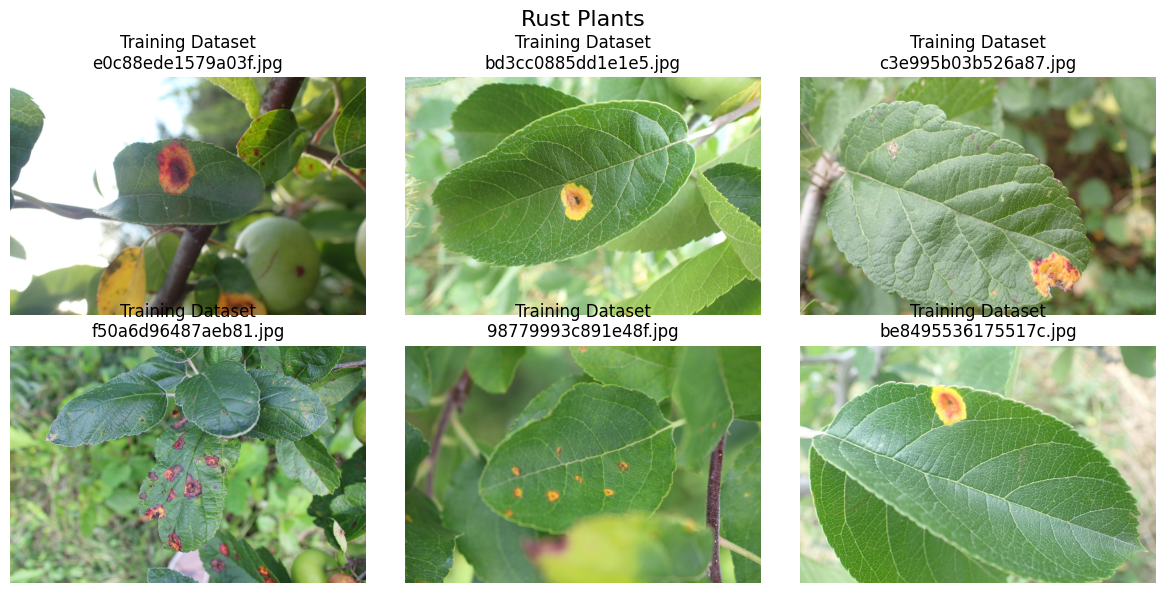

In [87]:
# Plotting rust plants
rust_images = [os.path.join(train_rust_dir, f) for f in rust_files]
plot_images_list(rust_images, "Rust Plants", "Training Dataset")

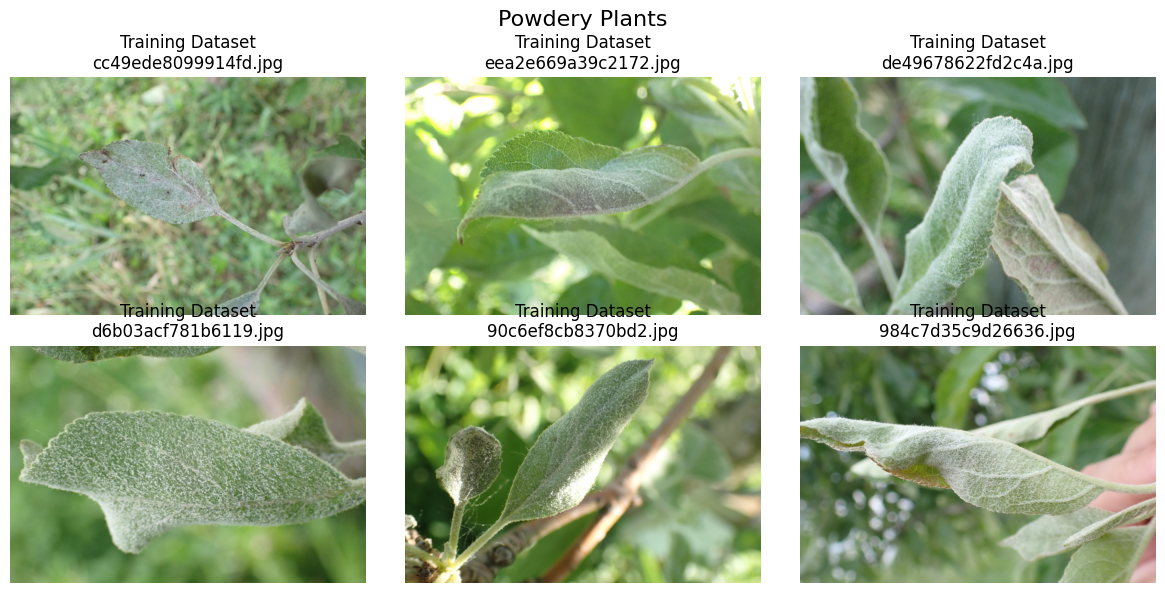

In [88]:
# Plotting powdery plants
powdery_images = [os.path.join(train_powdery_dir, f) for f in powdery_files]
plot_images_list(powdery_images, "Powdery Plants", "Training Dataset")

# 3. Load & Preprocess Data

# Preprocessing
## - Creating DataSets
    * Capture all files within each set for each of the classes
    * Fixed size for all images
        1. Resize the images
        2. Transform the input from rectangular shape to square shape
        3. Verifying the pixel valve range of the images - 0 to 1
        4. Same datatype

In [89]:
# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (256, 256), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 1322 files belonging to 3 classes.


In [90]:
# Creating a dataset for the Test data
test = tf.keras.utils.image_dataset_from_directory(
    test_dir,  
    labels = 'inferred', 
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    
    image_size = (256, 256), 
    shuffle = True,  
    seed = seed,  
    validation_split = 0, 
    crop_to_aspect_ratio = True 
)

Found 112 files belonging to 3 classes.


In [91]:
# Creating a dataset for the Test data
validation = tf.keras.utils.image_dataset_from_directory(
    val_dir,  
    labels = 'inferred', 
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    
    image_size = (256, 256),
    shuffle = True,  
    seed = seed,  
    validation_split = 0, 
    crop_to_aspect_ratio = True 
)

Found 60 files belonging to 3 classes.


### Results of preprocessing
* Same datatype - tf.float32
* Image_size - (256, 256)

###  3. Verifying the pixel valve range of the images - 0 to 1

In [92]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)
    
    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())
    
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 255.0


In [93]:
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1

In [94]:
# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y)) 
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

In [95]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)
    
    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())
    
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


# 4. Define Data Augmentation Pipeline
When working with image data, it is usually a good practice to artificially introduce some diversity to the sample by applying random transformations to the images used in training. This is good because it helps to expose the model to a wider variety of images and avoids overfitting.

Keras has about seven different layers for image data augmentation. 

* `tf.keras.layers.RandomRotation`: This layer randomly rotates the images during training, and also fills empty spaces according to the fill_mode attribute.
* ` tf.keras.layers.RandomContrast`: This layer randomly adjusts contrast by a random factor during training in or out on each axis of each image independently during training.
* ` tf.keras.layers.RandomBrightness`: This layer randomly increases/reduces the brightness for the input RGB images.

In [96]:
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),
        
        
        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),
        
        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

## Data Augmentation Pipeline

In [97]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# 5. Building CNN Architecture

##### Layers:
    1. Convolutional
    2. Pooling
    3. Fully-Connected Layers
    4. BatchNormalization - Maintains the mean output close to 0 and the standard deviation close to 1, help convergence and generalization. 
    5. Dropout - Sets a fraction of input units to 0 during training,prevent overfitting
    6. Flatten - Transforms a multi-dimensional tensor into a one-dimensional tensor


In [98]:
import tensorflow as tf

# Use MirroredStrategy for multiple GPUs (or 1 GPU + CPU)
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [99]:
# Initiating model on GPU
with strategy.scope():
    model = Sequential()

    model.add(augmentation) # Adding data augmentation pipeline to the model

    # Feature Learning Layers
    model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input. 
                    input_shape = (256,256,3) # Input image shape
                    ))
    model.add(Activation('relu'))# Activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(3, activation = 'softmax')) # Classification layer

# 6. Compile the Model

In [100]:
# Copiling model
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])
# Optimizers =  algorithms to adjust the weight updates. Choosing the right optimizer is essential to speed convergence
# Loss = loss function we're trying to minimize during training
# Metrics =  Metric that will be used to evaluate performance during training and validation.


# 7. Callbacks for Training

## Define an Early Stopping
Serves the purpose of interrupting the training process when a certain metric stops improving over a period of time.

In [101]:
# Defining an Early Stopping
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

## Define Model Checkpoints
Ensure that only the best weights get saved

In [102]:
# Model Checkpoints
checkpoint = ModelCheckpoint('best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

# 8. Train the Model

In [ ]:
# Training and Testing Model
try:
    history = model.fit(
        train, epochs = 50,
        validation_data = test,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/50
83/83 [==============================] - 287s 3s/step - loss: 6.2075 - accuracy: 0.5227 - val_loss: 0.9347 - val_accuracy: 0.4554
Epoch 2/50
83/83 [==============================] - 265s 3s/step - loss: 2.3921 - accuracy: 0.6377 - val_loss: 10.4517 - val_accuracy: 0.1071
Epoch 3/50
83/83 [==============================] - 259s 3s/step - loss: 1.7034 - accuracy: 0.7065 - val_loss: 6.2377 - val_accuracy: 0.1071
Epoch 4/50
83/83 [==============================] - 268s 3s/step - loss: 1.2254 - accuracy: 0.7489 - val_loss: 3.5780 - val_accuracy: 0.4732
Epoch 5/50
83/83 [==============================] - 263s 3s/step - loss: 0.9009 - accuracy: 0.7920 - val_loss: 0.8415 - val_accuracy: 0.7857
Epoch 6/50
83/83 [==============================] - 242s 3s/step - loss: 0.7440 - accuracy: 0.8238 - val_loss: 1.7148 - val_accuracy: 0.7500
Epoch 7/50
83/83 [==============================] - 239s 3s/step - loss: 0.6880 - accuracy: 0.8351 - val_loss: 0.9667 - val_accuracy: 0.8393
Epoch 8/50
8

### Observations:
The highest accuracy for the testing set has been reached at the 22nd epoch at 0.9600, or 96%, and didn't improve after that.
#### Showing both the loss function and accuracy for both sets over epochs

# 9. Evaluate & Visualize

In [ ]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Test',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

# Visualization of Model
* First we have a 2D Convolutional Layer, with ReLU activation function
* Followed by a BatchNormalization Layer and then a MaxPooling 2D Layer.
* Finally, we have a Dropout Layer to avoid overfitting.
* This same pattern repeats a few times until we reach the Flatten Layer, which connects the output of the Feature Learning process to the Dense Layers for the final classification task.

In [ ]:
tf.keras.utils.plot_model(model)

# Demonstration Model
* The summary displays the output shapes for each layer, as well as the number of parameters.
* The output shape for the first layer is (None, 256,256,3) where 256 represents both height and width, while 3 represents   the RGB color. In the last dense layer, however, the output shape is (None, 3), where 3 represents the three classes for   classification.
* We can also see that the model has over 69 million parameters, where 99.99% of them are trainable.
* The non-trainable parameters are the ones from the BatchNormalization layers.

In [ ]:
model.summary()

# 10. Load Best Weights & Validate

In [ ]:
# Loading best weights
model.load_weights('best_model.h5')

# 11. Run Predictions

In [ ]:
preds = model.predict(validation)  # Running model on the validation dataset,output contains probabilities for each clas
val_loss, val_acc = model.evaluate(validation) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

In [ ]:
# Loading an image from the Validation/ Powdery directory
image_path = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Powdery/9b6a318cc5721d73.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Powdery Plant: \n')
resized_img

In [ ]:
# Loading an image from the Validation/ Rust directory
image_path = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust/8152cfbd5a28b5d2.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Rust Plant: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

In [ ]:
# Loading an image from the Validation/ Healthy directory
image_path = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c99786a63786571.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Healthy Plant: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

# 12. Save Final Model

In [ ]:
model.save('plant_disease_classifier.h5') # Saving model